In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt 
import random
import math 
import time
import numpy as np

#local imports
from TransformerModules import Modelconfig, Block, MLP, CausalSelfAttention

In [122]:
class AttentionOnlyModel(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config 
        self.transformer = nn.ModuleDict(
            dict(
                wce = nn.Embedding(config.vocab_size, config.n_embed),
                wpe = nn.Embedding(config.block_size, config.n_embed),
                h = CausalSelfAttention(config)
                )
            )
        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)

    def forward(self, idx, targets = None):
        B, T = idx.shape
        assert T <= self.config.block_size, f"Cannot forward sequence of lenght {T}, block size is {self.config.block_size}"
        
        char_emb = self.transformer.wce(idx)
        pos_emb = self.transformer.wpe(torch.arange(0, T, dtype = torch.long))
        
        x = char_emb + pos_emb
        
        x = x+self.transformer.h(x)
        
        logits = self.lm_head(x)
        
        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


    def generate(self, idx, max_new_tokes):

        for _ in range(max_new_tokes):
            idx_cond = idx[:, -self.config.block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx 



In [123]:
# tools to build the basic A, B, C, A, B, C, ... patterned dataset
data = list('ABC'*1000)
c_to_i = {'A':0, 'B':1, 'C':2}
i_to_c = {i:c for c,i in c_to_i.items()}
encode = lambda s: [c_to_i[c] for c in s] 
decode = lambda l: ''.join([i_to_c[i] for i in l])


i_data = [c_to_i[c] for c in data]
i_data = torch.tensor(i_data, dtype=torch.long)

In [124]:
# get a batch of training data
def get_batch(model, batch_size):
	block_size = model.config.block_size
	ix = torch.randint(len(i_data)-block_size, (batch_size,))
	x = torch.stack([i_data[i:i+block_size] for i in ix])
	y = torch.stack([i_data[i+1:i+block_size+1] for i in ix])
	return x,y

In [125]:
@torch.no_grad()
def estimate_loss(model, batch_size, train_data, val_data, eval_iters):
	out = {}
	data = {'train': train_data, 'val': val_data}
	model.eval()
	for split in ['train', 'val']:
		losses = torch.zeros(eval_iters)
		for k in range(eval_iters):
			X, Y = get_batch(model, batch_size)
			logits, loss = model(X, Y)
			losses[k] = loss.item()
		out[split] = losses.mean()
	model.train()
	return out

In [126]:
def training_loop(model, optimizer, batch_size, max_iters, eval_interval, train_data, val_data, eval_iters):
	start_time = time.time()

	for iter in range(max_iters):

		if iter % eval_interval == 0:
			losses = estimate_loss(model, batch_size, train_data, val_data, eval_iters)
			print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

		# sample a batch of data
		xb, yb = get_batch(model, batch_size)

		# evaluation the loss
		logits, loss = model(xb, yb)
		optimizer.zero_grad(set_to_none=True)
		loss.backward()
		optimizer.step()

	losses = estimate_loss(model, batch_size, train_data, val_data, eval_iters)
	print(f"step {max_iters}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
	print(f"Took {(time.time() - start_time)//60} minutes to train")	

In [127]:
tinyconfig = Modelconfig
tinyconfig.block_size = 3
tinyconfig.vocab_size = 3
tinyconfig.n_layer = 1
tinyconfig.n_head = 1
tinyconfig.n_embed = 2


In [154]:
torch.manual_seed(1234)
# torch.manual_seed(2345)
one_layer_model = AttentionOnlyModel(tinyconfig)
optimizer = torch.optim.AdamW(one_layer_model.parameters(), )

max_iters=5000
# eval_interval=max_iters//100
eval_interval = 500
eval_iters = 200
batch_size = 64

In [155]:
training_loop(one_layer_model, optimizer, batch_size, max_iters, eval_interval, i_data, i_data, eval_iters)

step 0: train loss 1.0949, val loss 1.0938
step 500: train loss 0.2450, val loss 0.2442
step 1000: train loss 0.0126, val loss 0.0126
step 1500: train loss 0.0035, val loss 0.0035
step 2000: train loss 0.0016, val loss 0.0016
step 2500: train loss 0.0009, val loss 0.0009
step 3000: train loss 0.0005, val loss 0.0005
step 3500: train loss 0.0003, val loss 0.0003
step 4000: train loss 0.0002, val loss 0.0002
step 4500: train loss 0.0002, val loss 0.0002
step 5000: train loss 0.0001, val loss 0.0001
Took 0.0 minutes to train


In [156]:
for param_tensor in one_layer_model.state_dict():
		print(param_tensor, "\t", one_layer_model.state_dict()[param_tensor])

transformer.wce.weight 	 tensor([[ 1.1988,  1.3633],
        [-1.8032, -0.7401],
        [-1.0425,  1.4757]])
transformer.wpe.weight 	 tensor([[-0.3160,  0.9374],
        [-0.4459,  1.2218],
        [-0.2666,  0.9128]])
transformer.h.bias 	 tensor([[[[1., 0., 0.],
          [1., 1., 0.],
          [1., 1., 1.]]]])
transformer.h.c_attn.weight 	 tensor([[ 1.2264,  0.2659],
        [-0.6164, -0.8800],
        [ 1.3872,  0.0938],
        [-0.3563, -1.1420],
        [ 1.6535,  0.0707],
        [ 1.3057,  1.5810]])
transformer.h.c_attn.bias 	 tensor([-0.1574, -0.2179,  0.6120, -0.5666, -1.3549, -0.0821])
transformer.h.c_proj.weight 	 tensor([[1.5123, 1.2242],
        [0.4940, 1.7713]])
transformer.h.c_proj.bias 	 tensor([-0.9847,  0.3911])
lm_head.weight 	 tensor([[-0.5150,  1.2707],
        [ 1.1767,  1.2045],
        [-0.3778, -0.6578]])


In [179]:
#plot the embedding vectors
%matplotlib inline
emb_weights = one_layer_model.transformer.wce.weight.detach().numpy()
pos_weights = one_layer_model.transformer.wpe.weight.detach().numpy()
emb_weights

array([[ 1.1988192 ,  1.3633367 ],
       [-1.8031883 , -0.74013484],
       [-1.0424923 ,  1.47568   ]], dtype=float32)

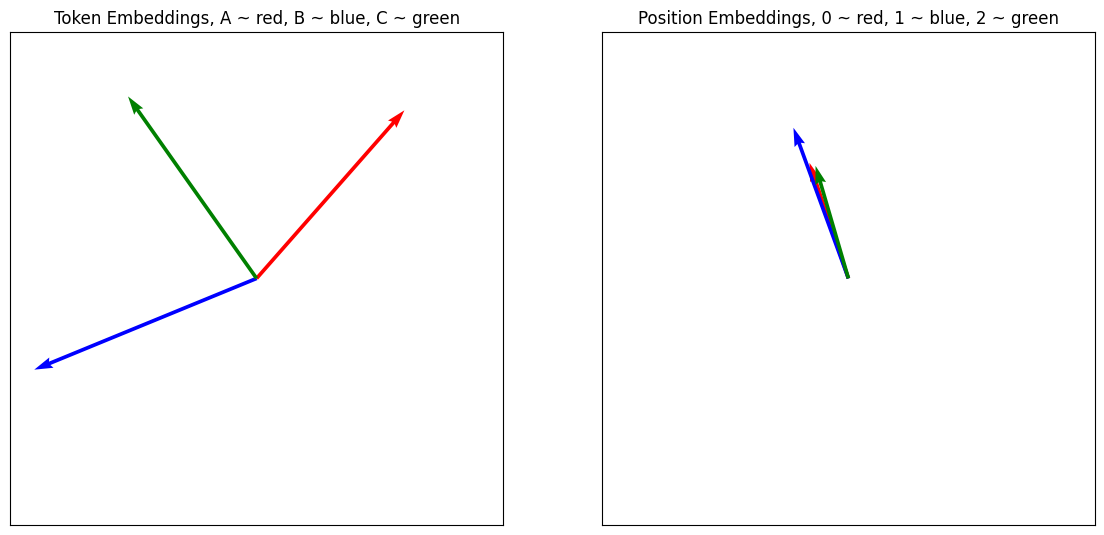

In [183]:
origin = np.array([[0,0,0],[0,0,0]])
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))
#plot 1
ax1.quiver(*origin, emb_weights[:,0], emb_weights[:,1], color=['r','b','g'], angles='xy', scale_units='xy', scale=1)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.axis([-2,2,-2,2])
ax1.set_aspect('equal')
ax1.set_title('Token Embeddings, A ~ red, B ~ blue, C ~ green')

#plot 2
ax2.quiver(*origin, pos_weights[:,0], pos_weights[:,1], color=['r','b','g'], angles='xy', scale_units='xy', scale=1)
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.axis([-2,2,-2,2])
ax2.set_aspect('equal')
ax2.set_title('Position Embeddings, 0 ~ red, 1 ~ blue, 2 ~ green')

plt.show()

In [157]:
logits, loss= one_layer_model(torch.zeros((1,1), dtype=torch.long))
print(logits.dtype)
print(logits)

torch.float32
tensor([[[11.0611, 20.5847, -9.6361]]], grad_fn=<UnsafeViewBackward0>)


In [158]:
x = torch.zeros((1,1), dtype = torch.long)
wce_x = one_layer_model.transformer.wce(x)
wpe_x = one_layer_model.transformer.wpe(torch.arange(0, 1, dtype = torch.long))
x.dtype

torch.int64

In [159]:
print("Weight embedding", "\t", wce_x)
print("Position embedding", "\t", wpe_x)

Weight embedding 	 tensor([[[1.1988, 1.3633]]], grad_fn=<EmbeddingBackward0>)
Position embedding 	 tensor([[-0.3160,  0.9374]], grad_fn=<EmbeddingBackward0>)


In [160]:
wt = one_layer_model.transformer.h.c_attn.weight.transpose(0,1)
bs = one_layer_model.transformer.h.c_attn.bias
wt.split(2, 1)

(tensor([[ 1.2264, -0.6164],
         [ 0.2659, -0.8800]], grad_fn=<SplitBackward0>),
 tensor([[ 1.3872, -0.3563],
         [ 0.0938, -1.1420]], grad_fn=<SplitBackward0>),
 tensor([[1.6535, 1.3057],
         [0.0707, 1.5810]], grad_fn=<SplitBackward0>))

In [161]:
embed_x = wce_x + wpe_x
print("Embedding", "\t", embed_x, embed_x.dtype)
transformer_x = one_layer_model.transformer.h.c_attn(embed_x)
q, k, v = transformer_x.split(2, dim=2)
print("Project x into transformer", "\t", transformer_x)
print("Q projection:", "\t", q)
print("K projection:", "\t", k)
print("V projection:", "\t", v)

Embedding 	 tensor([[[0.8829, 2.3007]]], grad_fn=<AddBackward0>) torch.float32
Project x into transformer 	 tensor([[[ 1.5369, -2.7868,  2.0524, -3.5085,  0.2676,  4.7082]]],
       grad_fn=<ViewBackward0>)
Q projection: 	 tensor([[[ 1.5369, -2.7868]]], grad_fn=<SplitBackward0>)
K projection: 	 tensor([[[ 2.0524, -3.5085]]], grad_fn=<SplitBackward0>)
V projection: 	 tensor([[[0.2676, 4.7082]]], grad_fn=<SplitBackward0>)


In [162]:
embed_x @ wt + bs

tensor([[[ 1.5369, -2.7868,  2.0524, -3.5085,  0.2676,  4.7082]]],
       grad_fn=<AddBackward0>)

In [163]:
x1 = torch.arange(0,3, dtype=torch.long).view(1,3)
wte_x1 = one_layer_model.transformer.wce(x1)
wpe_x1 = one_layer_model.transformer.wpe(torch.arange(0,3, dtype = torch.long))
print(wte_x1, wpe_x1)
embed_x1 = wte_x1+wpe_x1
print(embed_x1)

tensor([[[ 1.1988,  1.3633],
         [-1.8032, -0.7401],
         [-1.0425,  1.4757]]], grad_fn=<EmbeddingBackward0>) tensor([[-0.3160,  0.9374],
        [-0.4459,  1.2218],
        [-0.2666,  0.9128]], grad_fn=<EmbeddingBackward0>)
tensor([[[ 0.8829,  2.3007],
         [-2.2491,  0.4817],
         [-1.3090,  2.3885]]], grad_fn=<AddBackward0>)


In [164]:
one_layer_model(torch.arange(0,3, dtype=torch.long).view(1,3))

(tensor([[[ 11.0611,  20.5847,  -9.6361],
          [ -0.1213, -22.7889,   8.8397],
          [  7.8989,  -0.8341,  -0.8682]]], grad_fn=<UnsafeViewBackward0>),
 None)